<a href="https://colab.research.google.com/github/bjelikj/DT2119/blob/Lab3_Andres/Labs/Lab3/Lab3_V3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive/')

reload_files = False

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
"""
Necessary files:
- lab1_proto.py
- lab1_tools.py
- lab2_proto.py
- lab2_tools.py
- lab3_proto.py
- lab3_tools.py
- prondict.py
- standardization.py

If not uploaded to Google Drive:
- lab2_models_all.npz
- lab3_example.npz
"""

if reload_files:
  # %pwd
  !pwd
  if IN_COLAB:
      !rm -r ./*.py

  from google.colab import files
  files.upload()

In [3]:
from lab1_proto import *
from lab2_proto import *
from lab3_proto import *
from lab1_tools import *
from lab2_tools import *
from lab3_tools import *
from prondict import prondict
from standardization import *

import numpy as np
import os

Using TensorFlow backend.


## Check examples


In [0]:
example = np.load('/content/drive/My Drive/Lab3/lab3_example.npz', allow_pickle=True)['example'].item()

# 4.1 Target Class Definition

In [7]:
phoneHMMs = np.load('/content/drive/My Drive/Lab3/lab2_models_all.npz', allow_pickle=True)['phoneHMMs'].item()
phones = sorted(phoneHMMs.keys())
nstates = {phone: phoneHMMs[phone]['means'].shape[0] for phone in phones}
stateList = [ph + '_' + str(id) for ph in phones for id in range(nstates[ph])]
print(stateList)

['ah_0', 'ah_1', 'ah_2', 'ao_0', 'ao_1', 'ao_2', 'ay_0', 'ay_1', 'ay_2', 'eh_0', 'eh_1', 'eh_2', 'ey_0', 'ey_1', 'ey_2', 'f_0', 'f_1', 'f_2', 'ih_0', 'ih_1', 'ih_2', 'iy_0', 'iy_1', 'iy_2', 'k_0', 'k_1', 'k_2', 'n_0', 'n_1', 'n_2', 'ow_0', 'ow_1', 'ow_2', 'r_0', 'r_1', 'r_2', 's_0', 's_1', 's_2', 'sil_0', 'sil_1', 'sil_2', 'sp_0', 't_0', 't_1', 't_2', 'th_0', 'th_1', 'th_2', 'uw_0', 'uw_1', 'uw_2', 'v_0', 'v_1', 'v_2', 'w_0', 'w_1', 'w_2', 'z_0', 'z_1', 'z_2']


# 4.2 Forced Alignment

In [6]:
filename = '/content/drive/My Drive/tidigits/disc_4.1.1/tidigits/train/man/nw/z43a.wav'
samples, samplingrate = loadAudio(filename)
lmfcc = mfcc(samples)
print("LMFCC Shape: ", lmfcc.shape)

wordTrans = list(path2info(filename)[2])
print("Sequence of digits: ", wordTrans)

print("Pronunciation dictionary: ", prondict)

phoneTrans = words2phones(wordTrans, prondict)
print("Phone level transcription: ", phoneTrans)
utteranceHMM = concatHMMs(phoneHMMs, phoneTrans)

stateTrans = [phone + '_' + str(stateid) for phone in phoneTrans
              for stateid in range(nstates[phone])]

LMFCC Shape:  (178, 13)
Sequence of digits:  ['z', '4', '3']
Pronunciation dictionary:  {'o': ['ow'], 'z': ['z', 'iy', 'r', 'ow'], '1': ['w', 'ah', 'n'], '2': ['t', 'uw'], '3': ['th', 'r', 'iy'], '4': ['f', 'ao', 'r'], '5': ['f', 'ay', 'v'], '6': ['s', 'ih', 'k', 's'], '7': ['s', 'eh', 'v', 'ah', 'n'], '8': ['ey', 't'], '9': ['n', 'ay', 'n']}
Phone level transcription:  ['sil', 'z', 'iy', 'r', 'ow', 'sp', 'f', 'ao', 'r', 'sp', 'th', 'r', 'iy', 'sp', 'sil']


In [7]:
# Compare with examples
for i in example['utteranceHMM'].keys():
    print(compare(utteranceHMM[i], example['utteranceHMM'][i]))

obsloglik = log_multivariate_normal_density_diag(lmfcc, utteranceHMM['means'], utteranceHMM['covars'])
viterbi_loglik, viterbi_path = viterbi(obsloglik, np.log(utteranceHMM['startprob']), np.log(utteranceHMM['transmat']))
viterbiStateTrans = [stateTrans[idx] for idx in viterbi_path.astype(np.int64)] # Forced Alignment

print('Comparing obsloglik...', compare(obsloglik, example['obsloglik']))
print('Comparing viterbiPath...', compare(viterbi_path, example['viterbiPath']))
print('Comparing viterbiStateTrans...', np.all(viterbiStateTrans == example['viterbiStateTrans']))

frames = frames2trans(viterbiStateTrans, outfilename= ''.join(path2info(filename)[2:]) + '.lab')

True
True
True
True
Comparing obsloglik... True
Comparing viterbiPath... True
Comparing viterbiStateTrans... True


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


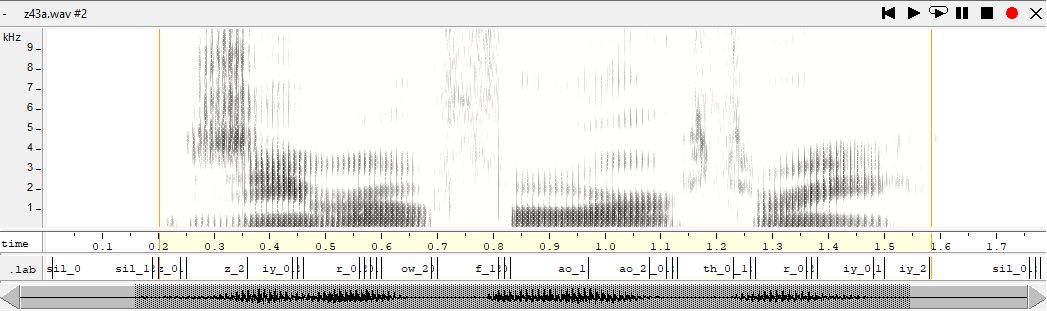

In [8]:
from IPython.display import Image
Image(filename='/content/drive/My Drive/Lab3/z43a_wavesurfer.png')

# 4.3 Feature Extraction

In [9]:
"""
from tqdm import tqdm
traindata = []
for root, dirs, files in tqdm(os.walk('/content/drive/My Drive/tidigits/disc_4.1.1/tidigits/train'), desc='dirs'):
  for file in files:
    if file.endswith('.wav'):
      filename = os.path.join(root, file)
      samples, samplingrate = loadAudio(filename)
      lmfcc, mspec_, targets =  extract_features_and_targets(filename)
      traindata.append({'filename': filename, 'lmfcc': lmfcc,
                        'mspec': mspec_, 'targets': targets})

np.savez('/content/drive/My Drive/Lab3/traindata.npz', traindata=traindata)
"""

"\nfrom tqdm import tqdm\ntraindata = []\nfor root, dirs, files in tqdm(os.walk('/content/drive/My Drive/tidigits/disc_4.1.1/tidigits/train'), desc='dirs'):\n  for file in files:\n    if file.endswith('.wav'):\n      filename = os.path.join(root, file)\n      samples, samplingrate = loadAudio(filename)\n      lmfcc, mspec_, targets =  extract_features_and_targets(filename)\n      traindata.append({'filename': filename, 'lmfcc': lmfcc,\n                        'mspec': mspec_, 'targets': targets})\n\nnp.savez('/content/drive/My Drive/Lab3/traindata.npz', traindata=traindata)\n"

In [10]:
"""
testdata = []
for root, dirs, files in tqdm(os.walk('/content/drive/My Drive/tidigits/disc_4.2.1/tidigits/test'), desc='dirs'):
  for file in files:
    if file.endswith('.wav'):
      filename = os.path.join(root, file)
      samples, samplingrate = loadAudio(filename)
      lmfcc, mspec_, targets =  extract_features_and_targets(filename)
      testdata.append({'filename': filename, 'lmfcc': lmfcc,
                        'mspec': mspec_, 'targets': targets})

np.savez('/content/drive/My Drive/Lab3/testdata.npz', testdata=testdata)
"""

"\ntestdata = []\nfor root, dirs, files in tqdm(os.walk('/content/drive/My Drive/tidigits/disc_4.2.1/tidigits/test'), desc='dirs'):\n  for file in files:\n    if file.endswith('.wav'):\n      filename = os.path.join(root, file)\n      samples, samplingrate = loadAudio(filename)\n      lmfcc, mspec_, targets =  extract_features_and_targets(filename)\n      testdata.append({'filename': filename, 'lmfcc': lmfcc,\n                        'mspec': mspec_, 'targets': targets})\n\nnp.savez('/content/drive/My Drive/Lab3/testdata.npz', testdata=testdata)\n"

# 4.4 Training and Validation Sets

In [0]:
#train_data = np.load('/content/drive/My Drive/Lab3/traindata.npz', allow_pickle=True)['traindata']

In [0]:
#train_val_split(train_data)

# 4.5 Acoustic Context (Dynamic Features)

In [0]:
train_data = np.load('/content/drive/My Drive/Lab3/training_data.npy', allow_pickle=True)
val_data = np.load('/content/drive/My Drive/Lab3/validation_data.npy', allow_pickle=True)
test_data = np.load('/content/drive/My Drive/Lab3/testdata.npz', allow_pickle=True)['testdata']

In [0]:
def create_non_dynamic_features(data):
    """ Puts lmfcc and mspec features in arrays that can used for training
    Arg
        data: list of dictionaries with keys: 'lmfcc', 'mspec' and 'targets'
    
    Output
        lmfcc_features: [NxD_lmfcc] where N is nr of all concatinated samples of all words in data
        mspec_features: [NxD_mspec] where N is nr of all concatinated samples of all words in data
        targets: [N,] index of state for each sample
    """
    
    D_lmfcc = data[0]['lmfcc'].shape[1]
    D_mspec = data[0]['mspec'].shape[1]
    N = sum([len(x['targets']) for x in data])

    # Features to be returned
    lmfcc_features = np.zeros((N,D_lmfcc))
    mspec_features = np.zeros((N,D_mspec))

    # Targets to be returned
    targets = []

    # through all data
    k = 0
    for x in tqdm(data): 
        times, dim = x['lmfcc'].shape
        ## for each timestep
        for i in range(times):
            lmfcc_features[k,:]=x['lmfcc'][i,:]
            mspec_features[k,:]=x['mspec'][i,:]
            k +=1
        targets = targets + x['targets']
    return lmfcc_features, mspec_features, targets

In [0]:
from tqdm import tqdm
def create_dynamic_features(data):
    """ create_dynamic_features: Creates dynamic features by concatinated 7 
        lmfcc or mspec featues together for each step

    Args:
        data: list of dictionaries with keys: 'lmfcc', 'mspec' and 'targets'
    
    Returns:
        lmfcc_features: [NxD_lmfcc * 7] where N = number of all concatinated samples of all words in data
        mspec_features: [NxD_mspec * 7] where N = of all concatinated samples of all words in data
        targets: [N,] index of state for each sample
    """
    
    D_lmfcc = data[0]['lmfcc'].shape[1]
    D_mspec = data[0]['mspec'].shape[1]
    N = sum([len(x['targets']) for x in data])

    # Features to be returned
    dynlmfcc_features = np.zeros((N, D_lmfcc * 7))
    dynmspec_features = np.zeros((N, D_mspec * 7))
    
    # Targets to be returned
    targets = []

    # through all data
    k = 0
    for x in tqdm(data): 

        times, dim = x['lmfcc'].shape
        # for each time step
        for i in range(times):
            if i < 3 or i >= times - 3:
                dynlmfcc_features[k, :] = np.hstack(np.pad(x['lmfcc'], pad_width=((3, 3), (0, 0)), mode='reflect')[i:i+7, :])
                dynmspec_features[k, :] = np.hstack(np.pad(x['mspec'], pad_width=((3, 3), (0, 0)), mode='reflect')[i:i+7, :])
            else:
                dynlmfcc_features[k,:] = np.hstack(x['lmfcc'][i-3:i+4, :])
                dynmspec_features[k,:] = np.hstack(x['mspec'][i-3:i+4, :])
            k +=1
        targets = targets + x['targets']

    return dynlmfcc_features, dynmspec_features, targets

In [16]:
# Features & Dynamic features

lmfcc_train_x, mspec_train_x, train_y = create_non_dynamic_features(train_data)
dynlmfcc_train_x, dynmspec_train_x, train_y = create_dynamic_features(train_data)
#np.save('/content/drive/My Drive/Lab3/lmfcc_train_x.npy', lmfcc_train_x)
#np.save('/content/drive/My Drive/Lab3/mspec_train_x.npy', mspec_train_x)
#np.save('/content/drive/My Drive/Lab3/dynlmfcc_train_x.npy', dynlmfcc_train_x)
#np.save('/content/drive/My Drive/Lab3/dynmspec_train_x.npy', dynmspec_train_x)
np.save('/content/drive/My Drive/Lab3/train_y.npy', train_y)

 36%|███▋      | 2805/7699 [00:16<00:31, 154.15it/s]

KeyboardInterrupt: ignored

In [0]:
del lmfcc_train_x
del mspec_train_x
del train_y
del train_data

In [0]:
lmfcc_val_x, mspec_val_x, val_y = create_non_dynamic_features(val_data)
dynlmfcc_val_x, dynmspec_val_x, val_y = create_dynamic_features(val_data)
np.save('/content/drive/My Drive/Lab3/lmfcc_val_x.npy', lmfcc_val_x)
np.save('/content/drive/My Drive/Lab3/mspec_val_x.npy', mspec_val_x)
np.save('/content/drive/My Drive/Lab3/dynlmfcc_val_x.npy', dynlmfcc_val_x)
np.save('/content/drive/My Drive/Lab3/dynmspec_val_x.npy', dynmspec_val_x)
np.save('/content/drive/My Drive/Lab3/val_y.npy', val_y)

In [0]:
lmfcc_test_x, mspec_test_x, test_y = create_non_dynamic_features(test_data)
dynlmfcc_test_x, dynmspec_test_x, test_y = create_dynamic_features(test_data)
np.save('/content/drive/My Drive/Lab3/lmfcc_test_x.npy', lmfcc_test_x)
np.save('/content/drive/My Drive/Lab3/mspec_test_x.npy', mspec_test_x)
np.save('/content/drive/My Drive/Lab3/dynlmfcc_test_x.npy', dynlmfcc_test_x)
np.save('/content/drive/My Drive/Lab3/dynmspec_test_x.npy', dynmspec_test_x)
np.save('/content/drive/My Drive/Lab3/test_y.npy', test_y)

# 4.6 Feature Standardisation

In [0]:
train_y_one_hot, val_y_one_hot, test_y_one_hot = normalize_targets(train_y, val_y, test_y, stateList)

#5 Phoneme Recognition with Deep Neural Networks

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
from standardization import *
import numpy as np

 36%|███▋      | 2805/7699 [00:29<00:31, 154.15it/s]

In [0]:
import matplotlib.pyplot as plt
def plot_history(history):

    fig, axs = plt.subplots(2)
    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")
    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="validation error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")
    plt.show()

In [0]:
def save_predictions(Y_test, Y_pred, featuretype):
    """ Saves the prediction indexes for Y_test amd Y_pred
    Args
        Y_test: [NxS] where N is nr of samples and S ist the number of possible outputs
        Y_pred: [NxS] where N is nr of samples and S ist the number of possible outputs
    """
    Y_test_indexes = Y_test.argmax(axis=1)
    Y_pred_indexes = Y_pred.argmax(axis=1)
    np.savez('/content/drive/My Drive/Lab3/predictions/'+featuretype+'_pred.npz', Y_test_indexes=Y_test_indexes, Y_pred_indexes=Y_pred_indexes )

### LMFCC features

In [0]:
lmfcc_train_x = np.load('/content/drive/My Drive/Lab3/lmfcc_train_x.npy', allow_pickle=True)
train_y = np.load('/content/drive/My Drive/Lab3/train_y.npy', allow_pickle=True)

lmfcc_val_x = np.load('/content/drive/My Drive/Lab3/lmfcc_val_x.npy', allow_pickle=True)
val_y = np.load('/content/drive/My Drive/Lab3/val_y.npy', allow_pickle=True)

lmfcc_test_x = np.load('/content/drive/My Drive/Lab3/lmfcc_test_x.npy', allow_pickle=True)
test_y = np.load('/content/drive/My Drive/Lab3/test_y.npy', allow_pickle=True)

In [0]:
# Normalize 
lmfcc_train_x, lmfcc_val_x, lmfcc_test_x = normalize_features(lmfcc_train_x, lmfcc_val_x, lmfcc_test_x)

In [0]:
train_y_one_hot, val_y_one_hot, test_y_one_hot = normalize_targets(train_y, val_y, test_y, stateList)

In [32]:
model = Sequential()

# A typical value for hidden nodes is 256, but you can experiment with this to see if convergence becomes faster or slower.
model.add(Dense(256, input_shape=(13,), activation='relu', dtype="float32"))
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))

model.add(Dense(61))
model.add(Activation('softmax', name='posterior'))

opt = Adam()
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 256)               3584      
_________________________________________________________________
dense_11 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_12 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_13 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_14 (Dense)             (None, 61)                15677     
_________________________________________________________________
posterior (Activation)       (None, 61)                0         
Total params: 216,637
Trainable params: 216,637
Non-trainable params: 0
________________________________________________

In [33]:
filepath = "/content/drive/My Drive/Lab3/weights.{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,
                             save_best_only=True, mode='max')

history = model.fit(lmfcc_train_x, train_y_one_hot, epochs=10, batch_size=256,
          validation_data = (lmfcc_val_x, val_y_one_hot), callbacks=checkpoint)

Epoch 1/10
5239/5248 [============================>.] - ETA: 0s - loss: 1.2546 - accuracy: 0.6086
Epoch 00001: val_accuracy improved from -inf to 0.62733, saving model to /content/drive/My Drive/Lab3/weights.01-0.63.hdf5
5248/5248 [==============================] - 16s 3ms/step - loss: 1.2544 - accuracy: 0.6086 - val_loss: 1.1707 - val_accuracy: 0.6273
Epoch 2/10
5232/5248 [============================>.] - ETA: 0s - loss: 1.1345 - accuracy: 0.6405
Epoch 00002: val_accuracy improved from 0.62733 to 0.63390, saving model to /content/drive/My Drive/Lab3/weights.02-0.63.hdf5
5248/5248 [==============================] - 15s 3ms/step - loss: 1.1345 - accuracy: 0.6405 - val_loss: 1.1464 - val_accuracy: 0.6339
Epoch 3/10
5242/5248 [============================>.] - ETA: 0s - loss: 1.0961 - accuracy: 0.6516
Epoch 00003: val_accuracy did not improve from 0.63390
5248/5248 [==============================] - 15s 3ms/step - loss: 1.0961 - accuracy: 0.6516 - val_loss: 1.1750 - val_accuracy: 0.6293


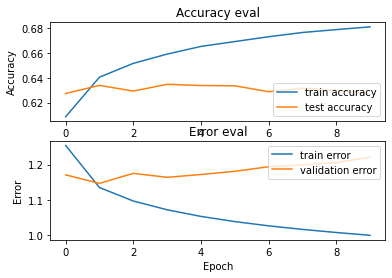

11928/11928 [==============================] - 24s 2ms/step - loss: 1.3514 - accuracy: 0.5963


In [42]:
plot_history(history)

score = model.evaluate(lmfcc_test_x, test_y_one_hot, batch_size=128)
# print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

pred_y = model.predict(lmfcc_test_x)
save_predictions(test_y_one_hot, pred_y, 'lmfcc')

## Filterbank features

In [0]:
# Load featyres
mspec_train_x = np.load('/content/drive/My Drive/Lab3/mspec_train_x.npy', allow_pickle=True)
mspec_val_x = np.load('/content/drive/My Drive/Lab3/mspec_val_x.npy', allow_pickle=True)
mspec_test_x = np.load('/content/drive/My Drive/Lab3/mspec_test_x.npy', allow_pickle=True)

In [0]:
# Normalize 
mspec_train_x, mspec_val_x, mspec_test_x = normalize_features(mspec_train_x, mspec_val_x, mspec_test_x)

In [45]:
model = Sequential()

# A typical value for hidden nodes is 256, but you can experiment with this to see if convergence becomes faster or slower.
model.add(Dense(256, input_shape=(40,), activation='relu', dtype="float32"))
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))

model.add(Dense(61))
model.add(Activation('softmax', name='posterior'))

opt = Adam()
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

filepath = "/content/drive/My Drive/Lab3/weights.{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,
                             save_best_only=True, mode='max')

history = model.fit(mspec_train_x, train_y_one_hot, epochs=10, batch_size=256,
          validation_data = (mspec_val_x, val_y_one_hot), callbacks=checkpoint)

Epoch 1/10
5238/5248 [============================>.] - ETA: 0s - loss: 1.2611 - accuracy: 0.6054
Epoch 00001: val_accuracy improved from -inf to 0.63257, saving model to /content/drive/My Drive/Lab3/weights.01-0.63.hdf5
5248/5248 [==============================] - 16s 3ms/step - loss: 1.2609 - accuracy: 0.6054 - val_loss: 1.1543 - val_accuracy: 0.6326
Epoch 2/10
5237/5248 [============================>.] - ETA: 0s - loss: 1.1024 - accuracy: 0.6504
Epoch 00002: val_accuracy improved from 0.63257 to 0.64220, saving model to /content/drive/My Drive/Lab3/weights.02-0.64.hdf5
5248/5248 [==============================] - 15s 3ms/step - loss: 1.1023 - accuracy: 0.6505 - val_loss: 1.1322 - val_accuracy: 0.6422
Epoch 3/10
5229/5248 [============================>.] - ETA: 0s - loss: 1.0496 - accuracy: 0.6657
Epoch 00003: val_accuracy improved from 0.64220 to 0.64797, saving model to /content/drive/My Drive/Lab3/weights.03-0.65.hdf5
5248/5248 [==============================] - 15s 3ms/step - los

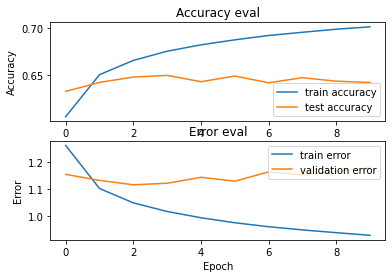

11928/11928 [==============================] - 25s 2ms/step - loss: 1.3056 - accuracy: 0.6133
accuracy: 61.33%


In [46]:
plot_history(history)

score = model.evaluate(mspec_test_x, test_y_one_hot, batch_size=128)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

pred_y = model.predict(mspec_test_x)
save_predictions(test_y_one_hot, pred_y, 'mspec')

## Dynamic LMFCC features

In [0]:
# dynlmfcc_train_x = np.load('/content/drive/My Drive/Lab3/dynlmfcc_train_x.npy', allow_pickle=True)
# dynlmfcc_val_x = np.load('/content/drive/My Drive/Lab3/dynlmfcc_val_x.npy', allow_pickle=True)
# dynlmfcc_test_x = np.load('/content/drive/My Drive/Lab3/dynlmfcc_test_x.npy', allow_pickle=True)

loaded = np.load('/content/drive/My Drive/Lab3_features/normalized/dynlmfcc_norm.npz', allow_pickle=True)
dynlmfcc_train_x =  loaded['dynlmfcc_train_x']
dynlmfcc_val_x = loaded['dynlmfcc_val_x']
dynlmfcc_test_x = loaded['dynlmfcc_test_x']

In [0]:
dynlmfcc_train_x, dynlmfcc_val_x, dynlmfcc_test_x = normalize_features(dynlmfcc_train_x, dynlmfcc_val_x, dynlmfcc_test_x)

In [49]:
model = Sequential()

# A typical value for hidden nodes is 256, but you can experiment with this to see if convergence becomes faster or slower.
model.add(Dense(256, input_shape=(91,), activation='relu', dtype="float32"))
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))

model.add(Dense(61))
model.add(Activation('softmax', name='posterior'))

opt = Adam()
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

filepath = "/content/drive/My Drive/Lab3/weights.{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,
                             save_best_only=True, mode='max')

history = model.fit(dynlmfcc_train_x, train_y_one_hot, epochs=10, batch_size=256,
          validation_data = (dynlmfcc_val_x, val_y_one_hot), callbacks=checkpoint)

Epoch 1/10
5243/5248 [============================>.] - ETA: 0s - loss: 0.7824 - accuracy: 0.7425
Epoch 00001: val_accuracy improved from -inf to 0.77611, saving model to /content/drive/My Drive/Lab3/weights.01-0.78.hdf5
5248/5248 [==============================] - 16s 3ms/step - loss: 0.7824 - accuracy: 0.7425 - val_loss: 0.6735 - val_accuracy: 0.7761
Epoch 2/10
5241/5248 [============================>.] - ETA: 0s - loss: 0.6202 - accuracy: 0.7886
Epoch 00002: val_accuracy improved from 0.77611 to 0.78681, saving model to /content/drive/My Drive/Lab3/weights.02-0.79.hdf5
5248/5248 [==============================] - 16s 3ms/step - loss: 0.6201 - accuracy: 0.7887 - val_loss: 0.6340 - val_accuracy: 0.7868
Epoch 3/10
5232/5248 [============================>.] - ETA: 0s - loss: 0.5714 - accuracy: 0.8030
Epoch 00003: val_accuracy improved from 0.78681 to 0.79315, saving model to /content/drive/My Drive/Lab3/weights.03-0.79.hdf5
5248/5248 [==============================] - 16s 3ms/step - los

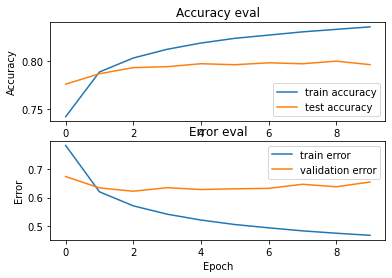

11928/11928 [==============================] - 24s 2ms/step - loss: 0.7777 - accuracy: 0.7674


In [50]:
plot_history(history)

score = model.evaluate(dynlmfcc_test_x, test_y_one_hot, batch_size=128)
# print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

pred_y = model.predict(dynlmfcc_test_x)
save_predictions(test_y_one_hot, pred_y, 'dynlmfcc')

## Dynamic Filterbank features

In [0]:
# dynmspec_train_x = np.load('/content/drive/My Drive/Lab3/dynmspec_train_x.npy', allow_pickle=True)
# dynmspec_val_x = np.load('/content/drive/My Drive/Lab3/dynmspec_val_x.npy', allow_pickle=True)
# dynmspec_test_x = np.load('/content/drive/My Drive/Lab3/dynmspec_test_x.npy', allow_pickle=True)

loaded = np.load('/content/drive/My Drive/Lab3_features/normalized/dynmspec_norm.npz', allow_pickle=True)
dynmspec_train_x =  loaded['dynmspec_train_x']
dynmspec_val_x = loaded['dynmspec_val_x']
dynmspec_test_x = loaded['dynmspec_test_x']

In [0]:
# dynmspec_train_x, dynmspec_val_x, dynmspec_test_x = normalize_features(dynmspec_train_x, dynmspec_val_x, dynmspec_test_x)

In [0]:
train_y = np.load('/content/drive/My Drive/Lab3/train_y.npy', allow_pickle=True)
val_y = np.load('/content/drive/My Drive/Lab3/val_y.npy', allow_pickle=True)
test_y = np.load('/content/drive/My Drive/Lab3/test_y.npy', allow_pickle=True)
train_y_one_hot, val_y_one_hot, test_y_one_hot = normalize_targets(train_y, val_y, test_y, stateList)

In [54]:
model = Sequential()

# A typical value for hidden nodes is 256, but you can experiment with this to see if convergence becomes faster or slower.
model.add(Dense(256, input_shape=(280,), activation='relu', dtype="float32"))
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))

model.add(Dense(61))
model.add(Activation('softmax', name='posterior'))

opt = Adam()
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

filepath = "/content/drive/My Drive/Lab3/weights.{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,
                             save_best_only=True, mode='max')

history = model.fit(dynmspec_train_x, train_y_one_hot, epochs=10, batch_size=256,
          validation_data = (dynmspec_val_x, val_y_one_hot), callbacks=checkpoint)

Epoch 1/10
5241/5248 [============================>.] - ETA: 0s - loss: 0.8265 - accuracy: 0.7273
Epoch 00001: val_accuracy improved from -inf to 0.75586, saving model to /content/drive/My Drive/Lab3/weights.01-0.76.hdf5
5248/5248 [==============================] - 16s 3ms/step - loss: 0.8264 - accuracy: 0.7273 - val_loss: 0.7142 - val_accuracy: 0.7559
Epoch 2/10
5242/5248 [============================>.] - ETA: 0s - loss: 0.6574 - accuracy: 0.7770
Epoch 00002: val_accuracy improved from 0.75586 to 0.77740, saving model to /content/drive/My Drive/Lab3/weights.02-0.78.hdf5
5248/5248 [==============================] - 17s 3ms/step - loss: 0.6573 - accuracy: 0.7771 - val_loss: 0.6652 - val_accuracy: 0.7774
Epoch 3/10
5237/5248 [============================>.] - ETA: 0s - loss: 0.6092 - accuracy: 0.7917
Epoch 00003: val_accuracy improved from 0.77740 to 0.78497, saving model to /content/drive/My Drive/Lab3/weights.03-0.78.hdf5
5248/5248 [==============================] - 16s 3ms/step - los

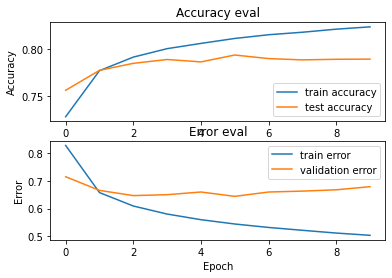

11928/11928 [==============================] - 25s 2ms/step - loss: 0.8145 - accuracy: 0.7592


In [55]:
plot_history(history)

score = model.evaluate(dynmspec_test_x, test_y_one_hot, batch_size=128)
# print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

pred_y = model.predict(dynmspec_test_x)
save_predictions(test_y_one_hot, pred_y, 'dynmspec')

# 5.1 Detailed Evaluation

In [0]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt  

In [0]:
phoneHMMs = np.load('/content/drive/My Drive/Lab3/lab2_models_all.npz', allow_pickle=True)['phoneHMMs'].item()
phones = sorted(phoneHMMs.keys())
nstates = {phone: phoneHMMs[phone]['means'].shape[0] for phone in phones}
stateList = [ph + '_' + str(id) for ph in phones for id in range(nstates[ph])]

In [0]:
def load_predictions(featuretype):
    """ Saves the prediction indexes for Y_test amd Y_pred
    Args
        featuretype: type of feature for which the preadictions should be load.
    Output
        Y_test_indexes: [N,] where N is nr of test outcomes
        Y_pred_indexes: [N,] where N is nr of predicted outcomes
    """
    with np.load('/content/drive/My Drive/Lab3/predictions/'+featuretype+'_pred.npz', allow_pickle=True) as data:
        Y_test_indexes = data['Y_test_indexes']
        Y_pred_indexes = data['Y_pred_indexes']
    return Y_test_indexes, Y_pred_indexes

In [9]:
def state_level_acc(Y_test_indexes,Y_pred_indexes):
    return sum(Y_test_indexes==Y_pred_indexes) / len(Y_test_indexes)


featuretypes = ['lmfcc','mspec','dynlmfcc','dynmspec']
for f in featuretypes:
    Y_test_indexes,Y_pred_indexes=load_predictions(f)
    frame_level_accuracy = state_level_acc(Y_test_indexes,Y_pred_indexes)
    print(f+" frame level accuracy: ", frame_level_accuracy)

lmfcc frame level accuracy:  0.5963488139638772
mspec frame level accuracy:  0.61326130785586
dynlmfcc frame level accuracy:  0.7673595418037286
dynmspec frame level accuracy:  0.7591862614480291


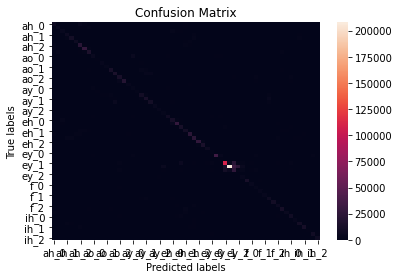

In [10]:
Y_test_indexes,Y_pred_indexes=load_predictions('lmfcc')
cm = confusion_matrix(Y_pred_indexes, Y_test_indexes)

ax= plt.subplot()
sns.heatmap(cm, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(stateList); ax.yaxis.set_ticklabels(stateList);

In [0]:
import editdistance

def state_level_edit_distance(Y_test_indexes, Y_pred_indexes):
    # transcript pred_states (i.e. ox1 ox2 ox3 -> ox)
    Y_pred_transcripted = []
    i = 0
    while True:
        if i >= len(Y_pred_indexes): break
        tmp = Y_pred_indexes[i]
        while i < len(Y_pred_indexes) and tmp==Y_pred_indexes[i]:
            i+=1
        Y_pred_transcripted.append(tmp)

    # transcript test_states
    Y_test_transcripted = []
    i = 0
    while True:
        if i >= len(Y_test_indexes): break
        tmp = Y_test_indexes[i]
        while i < len(Y_test_indexes) and tmp==Y_test_indexes[i]:
            i+=1
        Y_test_transcripted.append(tmp)
        
    # return editdistance.eval(Y_pred_transcripted, Y_test_transcripted)
    return Y_test_transcripted, Y_pred_transcripted

# featuretypes = ['lmfcc','mspec','dynlmfcc','dynmspec']
# for f in featuretypes:
#     Y_test_indexes,Y_pred_indexes = load_predictions(f)
#     pred, trans = state_level_edit_distance(Y_test_indexes, Y_pred_indexes)
    # edit_distance = state_level_edit_distance(Y_test_indexes, Y_pred_indexes)
    # print("The state level edit distance for "+f+" features is:",edit_distance)

In [0]:
test_y_indexes, pred_y_indexes = load_predictions('lmfcc')
test_y_transcript, pred_y_transcript = state_level_edit_distance(Y_test_indexes, Y_pred_indexes)
edit_distance = editdistance.eval(test_y_transcript, pred_y_transcript)

print("LMFCC state level edit distance:",edit_distance)